# Captcha Recognition #
To solve this problem, we found the dataset on kaggle. We first made an attempt to make a CNN from scratch, and after mediocre results and great difficulty, decided to use a tool we learned in class, fine-tuning a pretrained model. We first uploaded the dataset to a github repository and then created a custom class to make a DataLoader out of it. 
We used a multilabel classifier, dividing the output into a flattened 5*36 array, as each image had 5 character and each character could be any lowercase letter or number(adding up to 36).

To calculate the accuracy, we used two metrics:


1.   The percentage of perfect guesses
2.   The percentage of correct character guesses

The results were quite good considering our level of expertise. The percentage of characters guessed correctly came out to 94.58% and the percentage of perfect guesses was 79.16% on our test set.


Link: https://www.kaggle.com/fournierp/captcha-version-2-images



## Notebook Setup and Loading Data

*   Ensuring that GPU is available. It is required for the purposes of this assignment in order to maintain a manageable speed.
*   Downloading and unzipping the Dataset from hosted github repo

* Importing all the required libraries


In [0]:
import torch
torch.cuda.is_available()

True

In [0]:
%%capture
!wget "https://github.com/sg2nq/CaptchaDataset/raw/master/captcha-version-2-images.zip"
!unzip /content/captcha-version-2-images.zip

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.autograd import Variable
import random
import copy
import pandas as pd

plt.ion()


## Preprocessing and Visualizing


*   Defines the custom Dataset Class which creates labels for the input images and sets some variables
*   Transforming Data into the required input format for the neural network
* Creating PyTorch Data Loaders for the data split into Training, Testing and Validation sets
* Visualizing a sample from processed data



In [0]:
len_captcha = 5
categories = [char for char in "abcdefghijklmnopqrstuvwxyz0123456789"*len_captcha]
len_chars = len("abcdefghijklmnopqrstuvwxyz0123456789")
class CharacterDataset(Dataset):
  def __init__(self, path, transform=None):
    self.path = path
    self.img = os.listdir(self.path)
    self.transform = transform
    
  def __getitem__(self, idx):
    # Image conversion code was learned from PIL documentation
    img_path = self.img[idx]
    img = Image.open(os.path.join(self.path, img_path))
    img = img.convert('L')
    label_text = img_path.split('.')[0]
    label_arr = [0]*len(categories)
    for i, char in enumerate(label_text):
      pos = categories[i*len_chars:(i+1)*len_chars].index(char) + i*len_chars
      label_arr[pos] = 1
    img = self.transform(img)
    return img, np.array(label_arr), label_text
  
  def __len__(self):
    return len(self.img)


In [0]:
data_transforms = transforms.Compose([
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
    ])

image_datasets = CharacterDataset('./samples/samples', transform=data_transforms)

indices = list(range(len(image_datasets)))
random.shuffle(indices)
split = int(np.floor(0.7 * len(image_datasets)))
train_idx, valid_idx = indices[:split], indices[split:]
split = int(np.floor(0.3 * len(valid_idx)))
valid_idx, test_idx = valid_idx[split:], valid_idx[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)


train_dl = DataLoader(image_datasets, batch_size=64, num_workers=0, sampler = train_sampler)
val_dl = DataLoader(image_datasets, batch_size=64, num_workers=0, sampler = valid_sampler)
test_dl = DataLoader(image_datasets, batch_size=1, num_workers=0, sampler = test_sampler)


In [0]:
print(len(train_idx), len(valid_idx), len(test_idx))

749 225 96


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


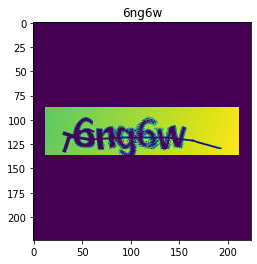

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, labels, label_test = next(iter(image_datasets))
i = 0 
output = ""
print(labels)
for k in range(len(labels)):
  if labels[k] == 1:
    output += categories[k]
imshow(inputs[i], title=output)



## Creating, Training and Visualizing model

* Downloading a pretrained ResNet18 
* Editing the input layer to take grayscale images
* Adding a linear as output
* Training the model using the Adam optimizer and Multi Label Soft Margin Loss function
* Visualizing the loss and comparison of training and validation accuracy using the absolute correctness metric
* Visualizing the final model



In [0]:
model = models.resnet18(pretrained=True)
# The idea of making this layer came from the complication that the input images were grayscale
# The remainder of the settings, aside from the number of channels, was copied from resnet
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(categories), bias=True)
criterion = nn.MultiLabelSoftMarginLoss() # https://pytorch.org/docs/stable/nn.html#multilabelsoftmarginloss
# seemed more fitting than BCEWithLogitsLoss but is the same thing

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.cuda();


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


In [0]:
def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 50):
  classifier = classifier.cuda()
  classifier.train()
  training_accuracy = []
  validation_accuracy = []
  loss_list = []
  best_model_wts = copy.deepcopy(classifier.state_dict())
  best_acc = 0.0

  for epoch in range(0, n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    classifier.train()
    correct = 0
    for x, y, label in trainLoader:
      # x = torch.reshape(x, (4, 3, 224, 224))
      x = Variable(x).cuda()
      y = Variable(y).cuda()
      yhat = classifier(x)
      loss = criterion(yhat, y)
      optimizer.zero_grad()      
      loss.backward()
      optimizer.step() # We can also use this utility from pytorch.

      with torch.no_grad():  # Stop recording operations for gradient computation.
        # Perfect prediction accuracy
        for k in range(len(yhat)): 
          temp_yhat = yhat[k].squeeze().cpu().tolist()
          pred = categories[np.argmax(temp_yhat[0*len_chars:1*len_chars])]
          pred += categories[np.argmax(temp_yhat[1*len_chars:2*len_chars])]
          pred += categories[np.argmax(temp_yhat[2*len_chars:3*len_chars])]
          pred += categories[np.argmax(temp_yhat[3*len_chars:4*len_chars])]
          pred += categories[np.argmax(temp_yhat[4*len_chars:])]
          # print(pred, label[k])
          if pred == label[k]:
            correct+=1
      classifier.train()

    n = len(train_idx)
    training_accuracy.append(correct / n)
    classifier.eval()
    correct = 0
    with torch.no_grad():
      for x, y, label in valLoader:
        # if x.shape != torch.Size([2, 1, 3, 224, 224]):
          # x = torch.reshape(x, (4, 3, 224, 224))
        x = Variable(x).cuda()
        y = Variable(y).cuda()
        yhat = classifier(x)
        for k in range(len(yhat)): 
          temp_yhat = yhat[k].squeeze().cpu().tolist()
          pred = categories[np.argmax(temp_yhat[0*len_chars:1*len_chars])]
          pred += categories[np.argmax(temp_yhat[1*len_chars:2*len_chars])]
          pred += categories[np.argmax(temp_yhat[2*len_chars:3*len_chars])]
          pred += categories[np.argmax(temp_yhat[3*len_chars:4*len_chars])]
          pred += categories[np.argmax(temp_yhat[4*len_chars:])]
          # print(pred, label[k])
          if pred == label[k]:
            correct+=1
    n = len(valid_idx)
    loss_list.append(loss.item())
    validation_accuracy.append(correct / n)
    print("Loss : {}, Training Accuracy: {}, Validation Accuracy: {}".format(
        loss_list[epoch], training_accuracy[epoch], validation_accuracy[epoch]))

  acc_df=pd.DataFrame({'x': range(0, len(training_accuracy)), 'y1': training_accuracy, 'y2': validation_accuracy})
  
  # multiple line plot
  plt.plot( 'x', 'y1', data=acc_df, marker='o', markerfacecolor='blue', markersize=2, color='skyblue', linewidth=1, label="Training Accuracy")
  plt.plot( 'x', 'y2', data=acc_df, marker='o', markerfacecolor='red', markersize=2, color='pink', linewidth=1, label="Validation Accuracy")
  plt.legend()
  plt.show()


  return classifier, loss_list

Epoch 0/99
----------
Loss : 0.1259913146495819, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 1/99
----------
Loss : 0.11321370303630829, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 2/99
----------
Loss : 0.10914972424507141, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 3/99
----------
Loss : 0.10853500664234161, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 4/99
----------
Loss : 0.10785544663667679, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 5/99
----------
Loss : 0.10347790271043777, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 6/99
----------
Loss : 0.09913598746061325, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 7/99
----------
Loss : 0.08942053467035294, Training Accuracy: 0.0, Validation Accuracy: 0.0
Epoch 8/99
----------
Loss : 0.08462736755609512, Training Accuracy: 0.0026702269692923898, Validation Accuracy: 0.0
Epoch 9/99
----------
Loss : 0.07255785912275314, Training Accuracy: 0.017356475300400534, V

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: Second argument 'y1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: Second argument 'y2' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


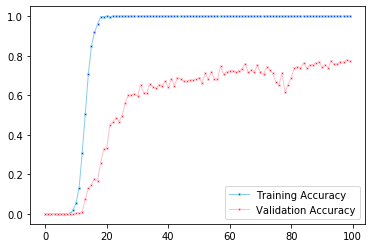

In [0]:
model_ft, loss_list = train_model(model, criterion, optimizer, train_dl, val_dl, n_epochs=100)

# Please scroll to the bottom of the run if you would like to see the 
# training vs validation accuracy graph

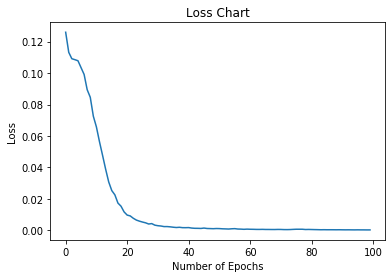

In [0]:
plt.title("Loss Chart")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.plot(loss_list)
plt.show()
# The graph below simply shows the final loss at the end of every epoch,
# not the loss calculated every after every prediction in training and validation

In [0]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Testing the Trained Network

Passing in the test data into the network that was previously hidden from the network to visualize results. 

In [0]:
num_chars_correct = 0
perfect_guess = 0
for step, (img, label_oh, label) in enumerate(test_dl):
    img = Variable(img).cuda()
    pred = model(img).squeeze().cpu().tolist()
    # print(len(pred.squeeze()))
    c0 = categories[np.argmax(pred[0:len_chars])]
    c1 = categories[np.argmax(pred[len_chars:len_chars*2])]
    c2 = categories[np.argmax(pred[len_chars*2:len_chars*3])]
    c3 = categories[np.argmax(pred[len_chars*3:len_chars*4])]
    c4 = categories[np.argmax(pred[len_chars*4:len_chars*5])]
    c = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
    if c0 == label[0][0]:
      num_chars_correct += 1
    if c1 == label[0][1]:
      num_chars_correct += 1
    if c2 == label[0][2]:
      num_chars_correct += 1
    if c3 == label[0][3]:
      num_chars_correct += 1
    if c4 == label[0][4]:
      num_chars_correct += 1
    if c0 == label[0][0] and c1 == label[0][1] and c2 == label[0][2] and c3 == label[0][3] and c4 == label[0][4]:
      perfect_guess += 1
    print('label:', label[0], 'pred:', c)

label: 4ycex pred: 4yccx
label: 7pcd7 pred: 7pcd7
label: 6p7gx pred: 6p7gx
label: 3n7mx pred: 3n7nx
label: c6f8g pred: c6f8g
label: 2npg6 pred: 2npg6
label: 8npe3 pred: 8npe3
label: 573bn pred: 573bn
label: y32yy pred: y32yy
label: 42xpy pred: 42xpy
label: 4b2pw pred: 4b2pw
label: pdcp4 pred: pdcp4
label: 3ygde pred: 3ygde
label: 6n6gg pred: 6n6gg
label: bc8nf pred: bc8nf
label: gcx6f pred: gce6f
label: nnfx3 pred: nnfx3
label: f74x3 pred: f78x3
label: x4pnp pred: x4pnp
label: 3p67n pred: 3p67n
label: p2dw7 pred: p2dw7
label: xxbm5 pred: xxbm5
label: w4x2m pred: w48cm
label: mfb3x pred: mfb3x
label: ncw4g pred: ncw4g
label: 5fyem pred: 5fyem
label: gm6nn pred: gm6nn
label: 37ep6 pred: 37ep6
label: 325fb pred: 325fb
label: fbp2c pred: fbp22
label: cdcb3 pred: edcb3
label: 5n245 pred: 5n245
label: mc35n pred: mcc5n
label: 4dw3w pred: 4dw3w
label: mp7wp pred: mmxwp
label: fg7mg pred: fg7ng
label: pg2pm pred: pggpm
label: 63pxe pred: 63pxe
label: yd755 pred: yd755
label: 6ecbn pred: 6ecbn


In [0]:
print(num_chars_correct/(len(test_idx)*5))
print(perfect_guess/(len(test_idx)))

0.9458333333333333
0.7916666666666666


## Final Notes ##
Given the small dataset, our model did a great job in predicting categories correct, with 94.58% of the characters in the test set correctly predicted